# Aprendizaje transferible (Transfer Learning)

Una de las grandes ventajas de las redes neuronales convolucionales (CNN) es su habilidad para extraer características básicas y muy precisas de los conjuntos de datos. Las primeras capas de las CNN constan de _filtros_ que extraen información como bordes, colores y figuras, por lo que se pretende utilizar este tipo de información en un conjunto de datos diferente.

La idea es simple y llamativa: si un modelo ha aprendido las formas y características de un conjunto de datos se puede hacer uso de esta información sobre un conjunto de datos **nuevo** que no haya sido visto aún por la CNN. Esto lleva por nombre **transfer learning** y su propósito es utilizar modelos y arquitecturas previamente entrenados para ser utilizados en otro tipo de datos.

En este documento se explora una aplicación simple, donde se pretende generalizar el conjunto de datos y el modelo empleado a un nuevo conjunto de datos. El ejemplo aquí presentado está basado en el [ejemplo](https://keras.io/examples/mnist_transfer_cnn/) de `keras` sobre _transfer learning._

In [186]:
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

## Fashion-MNIST

El conjunto de datos empleado es el [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que tiene 10 clases, cada una pertenece a un tipo de prenda o de calzado. La idea de este conjunto de datos (en realidad son imágenes) es que sirva como un reemplazo para el famoso conjunto de datos de dígitos escritos a mano del MNIST.

Las imágenes tienen un tamaño de $28 \times 28$ y están en tono de grises.

In [187]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [199]:
# Tamaño de lote para el optimizador
batch_size = 64
# Número de clases, ya se sabe por que se conoce el conjunto de datos
# pero si no, se puede hacer de forma programática
num_clases = 5
# Número de épocas, dejar como está porque es suficiente
epocas = 10
# Tamaño de los datos de entrada 
input_shape = (28, 28, 1)

In [200]:
x_train.shape

(60000, 28, 28)

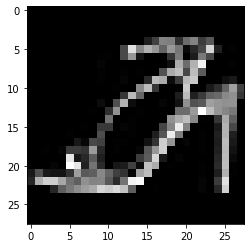

In [201]:
# Se puede visualizar una de estas imágenes para conocer el conjunto de datos
plt.imshow(x_train[82, :, :], cmap="gray")

## Preprocesamiento

La idea es separar el conjunto de datos en dos: las **primeras** 5 clases se utilizarán para entrenar al modelo, aprender las características principales y generalizarlas. Después, las **últimas** 5 clases se alimentarán al modelo pero los _filtros_ de características no se actualizarán, solamente se hará una clasificación.

Para esto se van a separar los conjuntos de datos, unos con las primeras 5 clases y las clases que restan.

In [204]:
# Tomar los índices de las primeras 5 clases, entrenamiento y prueba
idx_train_lt5 = np.squeeze(y_train < 5)
idx_test_lt5 = np.squeeze(y_test < 5)
# Tomar los índices de las últimas 5 clases, entrenamiento y prueba
idx_train_gte5 = np.squeeze(y_train >= 5)
idx_test_gte5 = np.squeeze(y_test >= 5)

Con los índices de las clases se puede separar el conjunto de datos de la siguiente forma.

In [205]:
# Las primeras 5 clases, entrenamiento y prueba, junto con sus etiquetas
x_train_lt5 = x_train[idx_train_lt5]
y_train_lt5 = y_train[idx_train_lt5]
x_test_lt5 = x_test[idx_test_lt5]
y_test_lt5 = y_test[idx_test_lt5]
# Las últimas 5 clases, entrenamiento y prueba
x_train_gte5 = x_train[idx_train_gte5]
# A las etiquetas hay que restarles 5 para asegurar que se tienen las últimas
y_train_gte5 = y_train[idx_train_gte5] - 5
x_test_gte5 = x_test[idx_test_gte5]
y_test_gte5 = y_test[idx_test_gte5] - 5

Para facilitar el entrenamiento se crea una función que realiza todas las operaciones necesarias.

In [206]:
def train_model(model, train, test, num_classes):
    # Reajustar el formato de las imágenes
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    # Normalizar las imágenes
    x_train /= 255
    x_test /= 255
    # Mostrar información relevante
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # Codificar mediante OneHot
    y_train = to_categorical(train[1], num_classes)
    y_test = to_categorical(test[1], num_classes)
    # Compilar el modelo
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])
    # Entrenar el modelo y realizar la validación
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epocas,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

## Arquitectura

La arquitectura es muy simple, consta de dos capas de 32 unidades de filtros $3 \times 3$, funciones de activación ReLU. La última capa es totalmente conectada de 128 unidades, y empleando _dropout_ de 25% para los filtros y de 50% para parte totalmente conectada.

Aquí la implementación es diferente, se separan los tipos de capas dado que en la primera parte se van a ajustar los filtros de características, pero en la segunda parte se van a omitir.

In [207]:
# Estas son las capas de características
feature_layers = [
    Conv2D(32, kernel_size=(3, 3),
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(32, kernel_size=(3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
]
# Y esta es la capa que realiza la clasificación
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_clases),
    Activation('softmax')
]

In [208]:
model = Sequential(feature_layers + classification_layers)

## Entrenamiento: primeras 5 clases

En esta parte del entrenamiento se va a entrenar y validar el modelo con las primeras 5 clases que se habían separado desde el principio, durante 10 épocas de entrenamiento. Aquí se van a ajustar los filtros de características y se va a clasificar el conjunto de validación.

Este es el modelo que se va a entrenar y genalizará las características para las últimas 5 capas.

In [209]:
train_model(model,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_clases)

x_train shape: (30000, 28, 28, 1)
30000 train samples
5000 test samples
Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 27s 904us/step - loss: 0.4049 - acc: 0.8620 - val_loss: 0.2417 - val_acc: 0.9126
Epoch 2/10
30000/30000 [==============================] - 27s 889us/step - loss: 0.2482 - acc: 0.9137 - val_loss: 0.1991 - val_acc: 0.9288
Epoch 3/10
30000/30000 [==============================] - 26s 880us/step - loss: 0.2123 - acc: 0.9266 - val_loss: 0.2279 - val_acc: 0.9170
Epoch 4/10
30000/30000 [==============================] - 26s 864us/step - loss: 0.1862 - acc: 0.9350 - val_loss: 0.1853 - val_acc: 0.9330
Epoch 5/10
30000/30000 [==============================] - 28s 934us/step - loss: 0.1692 - acc: 0.9383 - val_loss: 0.1689 - val_acc: 0.9436
Epoch 6/10
30000/30000 [==============================] - 27s 894us/step - loss: 0.1538 - acc: 0.9445 - val_loss: 0.1723 - val_acc: 0.9424
Epoch 7/10
30000/30000 [=====================

## Entrenamiento: últimas 5 capas

Ahora se van a _congelar_ las capas de características, esto es que **no se van a actualizar.** El propósito de _transfer learning_ es utilizar las características ya aprendidas en el modelo entrenado y clasificar un conjunto de datos totalmente diferente.

In [210]:
# Congelar todas los filtros de convolución
for l in feature_layers:
    l.trainable = False

In [212]:
train_model(model,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_clases)

x_train shape: (30000, 28, 28, 1)
30000 train samples
5000 test samples
Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 17s 560us/step - loss: 0.3705 - acc: 0.8854 - val_loss: 0.1008 - val_acc: 0.9644
Epoch 2/10
30000/30000 [==============================] - 15s 516us/step - loss: 0.1177 - acc: 0.9603 - val_loss: 0.0761 - val_acc: 0.9748
Epoch 3/10
30000/30000 [==============================] - 16s 543us/step - loss: 0.0864 - acc: 0.9701 - val_loss: 0.0710 - val_acc: 0.9748
Epoch 4/10
30000/30000 [==============================] - 16s 523us/step - loss: 0.0709 - acc: 0.9741 - val_loss: 0.0700 - val_acc: 0.9774
Epoch 5/10
30000/30000 [==============================] - 15s 513us/step - loss: 0.0615 - acc: 0.9786 - val_loss: 0.0642 - val_acc: 0.9784
Epoch 6/10
30000/30000 [==============================] - 15s 503us/step - loss: 0.0550 - acc: 0.9799 - val_loss: 0.0647 - val_acc: 0.9796
Epoch 7/10
30000/30000 [=====================

## Conclusiones

El resultado es excelente, al entrenar el modelo con las _primeras_ 5 capas se obtiene una precisión de validación de 94.2%. Cuando se generaliza este modelo a las _últimas_ 5 capas se obtiene una precisión de 98.2%. Esto implica que la técnica de _transfer learning_ es muy buena cuando se tienen conjuntos de datos con **características semejantes.**

En otras ocasiones se puede hacer uso de conjuntos de datos más grandes, de diferentes tipos, para resolver un problema semejante, pero se debe tomar en cuenta que los conjuntos de datos deben de tener _características semejantes_ para que esta técnica funcione adecuadamente.